In [1]:
!pip install -U pm4py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.5 MB 4.7 MB/s 
  Created wheel for stringdist: filename=StringDist-1.0.9-cp38-cp38-linux_x86_64.whl size=24203 sha256=fa4692b6830d75b2a1328a5053bf828f183b9087d8a4d76edc87aca353513e7c
  Stored in directory: /root/.cache/pip/wheels/7a/64/e2/16f6a25a62a78f951c1715adb24ba2271ae9d7872f42378c3a
Successfully built stringdist


In [2]:
!apt-get -qq install -y graphviz && pip install -q pydot

In [3]:
import os
import sys
import datetime
import ipywidgets as widgets
from ipywidgets import interact
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pm4py

#statistics of log
from pm4py import statistics

# object.log
from pm4py.objects.log.util import dataframe_utils
from pm4py.objects.log.exporter.xes import exporter as xes_exporter
from pm4py.objects.log.importer.xes import importer as xes_importer

# object.conversion
from pm4py.objects.conversion.dfg import converter as dfg_converter
from pm4py.objects.conversion.process_tree import converter as pt_converter

# algo.discovery
from pm4py.algo.discovery.alpha import variants
from pm4py.algo.filtering.log.variants import variants_filter
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.algo.discovery.inductive import algorithm as inductive_miner

# algo.conformance
from pm4py.algo.conformance.tokenreplay import algorithm as token_replay

# vizualization
from pm4py.visualization.petri_net import visualizer as pn_visualizer
from pm4py.visualization.dfg import visualizer as dfg_visualization
from pm4py.visualization.process_tree import visualizer as pt_visualizer
from pm4py.visualization.heuristics_net import visualizer as hn_visualizer
import warnings

warnings.filterwarnings("ignore")

In [37]:
from pm4py import statistics

## Version 

In [5]:
# Version Checking
pd.DataFrame(
    [
        ['pandas', pd.__version__], 
        ['numpy ', np.__version__], 
        ['matplotlib', sys.modules['matplotlib'].__version__], 
        ['ipywidgets', sys.modules['ipywidgets'].__version__],
        ['pm4py', pm4py.__version__],
    ], 
    columns = ['package', 'version']
).set_index('package')

,version
package,
pandas,1.3.5
numpy,1.21.6
matplotlib,3.2.2
ipywidgets,7.7.1
pm4py,2.3.4


## Read Data

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Preparation

In [ ]:
### Load .xes format with pm4py
log = pm4py.read_xes("/content/drive/MyDrive/financial_log.xes")
#df.to_csv('financial')

In [ ]:
log.head()

,org:resource,lifecycle:transition,concept:name,time:timestamp,case:REG_DATE,case:concept:name,case:AMOUNT_REQ
0,112,COMPLETE,A_SUBMITTED,2011-09-30 22:38:44.546000+00:00,2011-09-30 22:38:44.546000+00:00,173688,20000
1,112,COMPLETE,A_PARTLYSUBMITTED,2011-09-30 22:38:44.880000+00:00,2011-09-30 22:38:44.546000+00:00,173688,20000
2,112,COMPLETE,A_PREACCEPTED,2011-09-30 22:39:37.906000+00:00,2011-09-30 22:38:44.546000+00:00,173688,20000
3,112,SCHEDULE,W_Completeren aanvraag,2011-09-30 22:39:38.875000+00:00,2011-09-30 22:38:44.546000+00:00,173688,20000
4,NaN,START,W_Completeren aanvraag,2011-10-01 09:36:46.437000+00:00,2011-09-30 22:38:44.546000+00:00,173688,20000


In [ ]:
log.shape

(262200, 7)

In [ ]:
log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262200 entries, 0 to 262199
Data columns (total 7 columns):
 #   Column                Non-Null Count   Dtype              
---  ------                --------------   -----              
 0   org:resource          244190 non-null  object             
 1   lifecycle:transition  262200 non-null  object             
 2   concept:name          262200 non-null  object             
 3   time:timestamp        262200 non-null  datetime64[ns, UTC]
 4   case:REG_DATE         262200 non-null  datetime64[ns, UTC]
 5   case:concept:name     262200 non-null  object             
 6   case:AMOUNT_REQ       262200 non-null  object             
dtypes: datetime64[ns, UTC](2), object(5)
memory usage: 14.0+ MB


In [ ]:
log.isna().sum()

org:resource            18010
lifecycle:transition        0
concept:name                0
time:timestamp              0
case:REG_DATE               0
case:concept:name           0
case:AMOUNT_REQ             0
dtype: int64

In [ ]:
#Change AMOUNT_REQ to numeric
log['case:AMOUNT_REQ'] = pd.to_numeric(log['case:AMOUNT_REQ'])

In [ ]:
log.sample(frac=0.25)

,org:resource,lifecycle:transition,concept:name,time:timestamp,case:REG_DATE,case:concept:name,case:AMOUNT_REQ
39545,NaN,SCHEDULE,W_Nabellen offertes,2011-10-24 18:56:03.574000+00:00,2011-10-24 18:43:57.213000+00:00,179558,20000
14354,10881,COMPLETE,A_PREACCEPTED,2011-10-10 07:31:35.257000+00:00,2011-10-09 09:46:17.671000+00:00,175687,19000
144164,10972,START,W_Valideren aanvraag,2012-01-04 09:12:23.560000+00:00,2011-12-28 14:19:20.221000+00:00,196096,15000
237233,11009,START,W_Nabellen offertes,2012-03-14 11:49:01.417000+00:00,2012-02-15 21:13:18.716000+00:00,209945,12500
164973,10629,COMPLETE,W_Valideren aanvraag,2012-01-24 15:21:32.299000+00:00,2012-01-08 13:29:18.515000+00:00,199002,5000
...,...,...,...,...,...,...,...
11723,10629,START,W_Valideren aanvraag,2011-10-26 12:04:37.692000+00:00,2011-10-07 09:31:57.922000+00:00,175293,7800
63065,10982,COMPLETE,W_Completeren aanvraag,2011-11-08 11:13:24.729000+00:00,2011-11-07 19:58:15.989000+00:00,182951,4000
150814,11181,COMPLETE,W_Nabellen offertes,2012-01-28 13:01:06.504000+00:00,2012-01-01 19:38:50.252000+00:00,197002,35000
68813,11180,COMPLETE,W_Nabellen offertes,2011-11-24 17:31:09.714000+00:00,2011-11-10 12:13:05.209000+00:00,183820,6000


In [ ]:
#Unique Values 
pd.DataFrame(
    {
        'variable':log.columns,
        'unique values':[log[col].nunique() for col in log.columns],
        'fraction' :[round(log[col].nunique() / log.shape[0], 2) for col in log.columns]
    }
).set_index('variable')

,unique values,fraction
variable,,
org:resource,68,0.00
lifecycle:transition,3,0.00
concept:name,24,0.00
time:timestamp,248189,0.95
case:REG_DATE,13087,0.05
case:concept:name,13087,0.05
case:AMOUNT_REQ,631,0.00


In [8]:
log.rename(columns={"case:concept:name": "case_id", "concept:name": "activity", "time:timestamp":"timestamp"}, inplace=True)

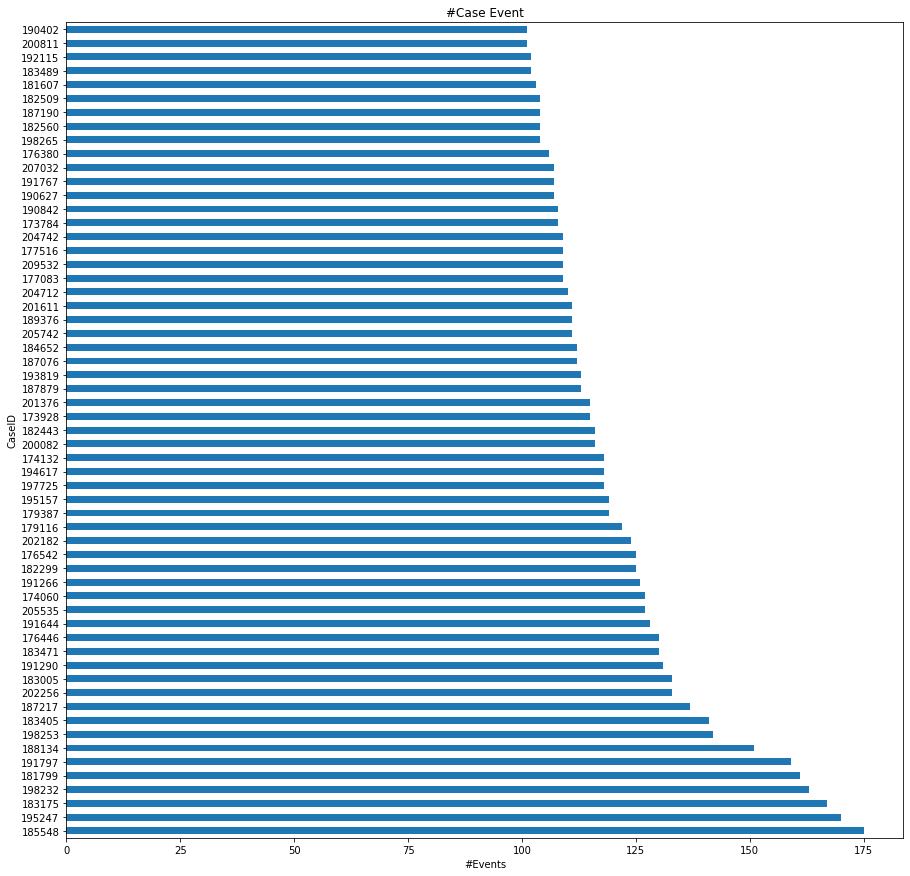

In [ ]:
#Plot number of case event that greater than 100
plt.figure(figsize=(15, 15))
log['case_id'].value_counts()[log['case_id'].value_counts() > 100].plot(y='case_id', kind='barh', title='#Case Event')
plt.xlabel('#Events')
plt.ylabel('CaseID')
plt.show()

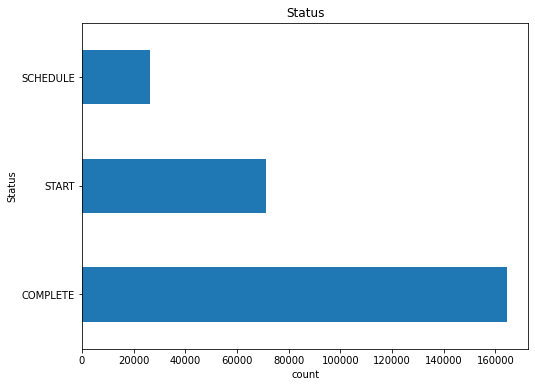

In [ ]:
# Value_counts: Status
plt.figure(figsize=(8, 6))
log['lifecycle:transition'].value_counts().plot(y='lifecycle:transition', kind='barh', title='Status')
plt.ylabel('Status')
plt.xlabel('count')
plt.show()

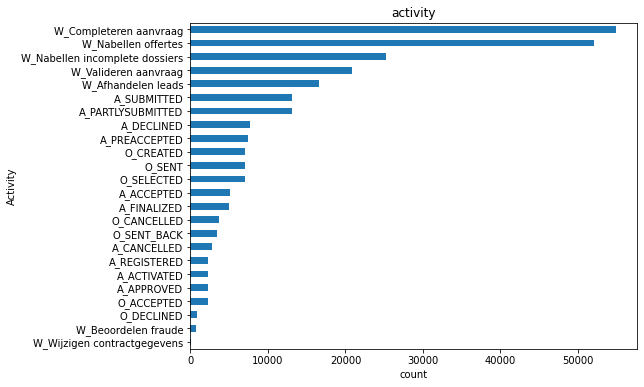

In [ ]:
# Value_counts: Activity
plt.figure(figsize=(8, 6))
log['activity'].value_counts().sort_values().plot(y='activity', kind='barh', title='activity')
plt.ylabel('Activity')
plt.xlabel('count')
plt.show()

In [ ]:
log['timestamp'].nunique()

248189

In [ ]:
log.loc[log['timestamp'].value_counts()[log['timestamp'].value_counts() > 1]]

,org:resource,lifecycle:transition,activity,timestamp,case:REG_DATE,case_id,case:AMOUNT_REQ
4,NaN,START,W_Completeren aanvraag,2011-10-01 09:36:46.437000+00:00,2011-09-30 22:38:44.546000+00:00,173688,20000
4,NaN,START,W_Completeren aanvraag,2011-10-01 09:36:46.437000+00:00,2011-09-30 22:38:44.546000+00:00,173688,20000
4,NaN,START,W_Completeren aanvraag,2011-10-01 09:36:46.437000+00:00,2011-09-30 22:38:44.546000+00:00,173688,20000
4,NaN,START,W_Completeren aanvraag,2011-10-01 09:36:46.437000+00:00,2011-09-30 22:38:44.546000+00:00,173688,20000
4,NaN,START,W_Completeren aanvraag,2011-10-01 09:36:46.437000+00:00,2011-09-30 22:38:44.546000+00:00,173688,20000
...,...,...,...,...,...,...,...
2,112,COMPLETE,A_PREACCEPTED,2011-09-30 22:39:37.906000+00:00,2011-09-30 22:38:44.546000+00:00,173688,20000
2,112,COMPLETE,A_PREACCEPTED,2011-09-30 22:39:37.906000+00:00,2011-09-30 22:38:44.546000+00:00,173688,20000
2,112,COMPLETE,A_PREACCEPTED,2011-09-30 22:39:37.906000+00:00,2011-09-30 22:38:44.546000+00:00,173688,20000
2,112,COMPLETE,A_PREACCEPTED,2011-09-30 22:39:37.906000+00:00,2011-09-30 22:38:44.546000+00:00,173688,20000


In [ ]:
log['timestamp'].value_counts()[log['timestamp'].value_counts() > 1]

2012-01-05 09:01:25.057000+00:00    4
2012-02-15 09:58:23.094000+00:00    4
2012-02-14 15:48:12.271000+00:00    4
2012-02-28 09:00:22.506000+00:00    4
2011-12-29 09:00:11.803000+00:00    4
                                   ..
2011-10-08 10:45:57.789000+00:00    2
2011-11-28 12:00:21.795000+00:00    2
2011-10-26 12:48:48.728000+00:00    2
2011-10-24 15:20:06.475000+00:00    2
2011-10-05 11:42:24.925000+00:00    2
Name: timestamp, Length: 11389, dtype: int64

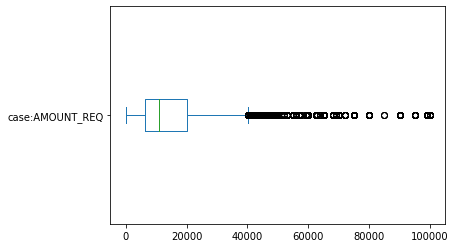

In [ ]:
# Value_distribution:AMOUNT_REQ
log['case:AMOUNT_REQ'].plot(kind='box', vert=False)
plt.show()

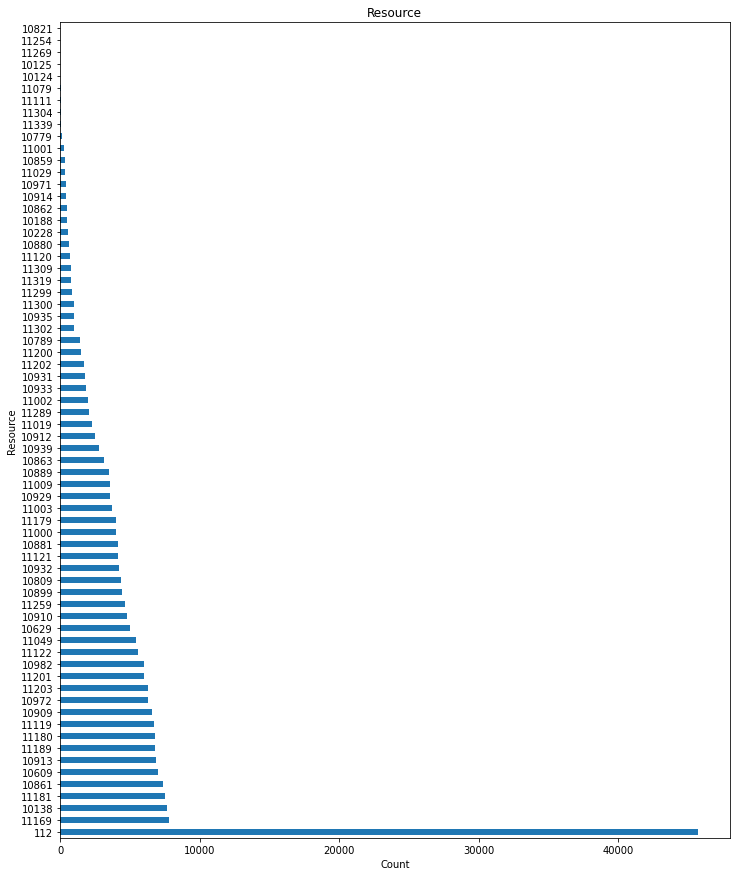

In [ ]:
# Value_counts:Resource
plt.figure(figsize=(12, 15))
log['org:resource'].value_counts().plot(kind='barh', y='org:resource', title='Resource')
plt.xlabel('Count')
plt.ylabel('Resource')
plt.show()

In [ ]:
log.sort_values('timestamp').groupby('case_id').head()

,org:resource,lifecycle:transition,activity,timestamp,case:REG_DATE,case_id,case:AMOUNT_REQ
0,112,COMPLETE,A_SUBMITTED,2011-09-30 22:38:44.546000+00:00,2011-09-30 22:38:44.546000+00:00,173688,20000
1,112,COMPLETE,A_PARTLYSUBMITTED,2011-09-30 22:38:44.880000+00:00,2011-09-30 22:38:44.546000+00:00,173688,20000
2,112,COMPLETE,A_PREACCEPTED,2011-09-30 22:39:37.906000+00:00,2011-09-30 22:38:44.546000+00:00,173688,20000
3,112,SCHEDULE,W_Completeren aanvraag,2011-09-30 22:39:38.875000+00:00,2011-09-30 22:38:44.546000+00:00,173688,20000
26,112,COMPLETE,A_SUBMITTED,2011-10-01 06:08:58.256000+00:00,2011-10-01 06:08:58.256000+00:00,173691,5000
...,...,...,...,...,...,...,...
261921,11203,START,W_Completeren aanvraag,2012-03-01 15:28:46.970000+00:00,2012-02-29 20:06:59.646000+00:00,214304,15000
261904,11203,START,W_Completeren aanvraag,2012-03-01 15:31:43.012000+00:00,2012-02-29 20:00:31.126000+00:00,214298,50000
262057,11299,START,W_Completeren aanvraag,2012-03-01 15:32:51.084000+00:00,2012-02-29 21:37:31.192000+00:00,214352,8000
262035,11203,START,W_Completeren aanvraag,2012-03-01 15:54:21.907000+00:00,2012-02-29 21:24:30.324000+00:00,214346,12500


In [9]:
log2 = log[['case_id','activity','timestamp','org:resource']]
log2.head()

,case_id,activity,timestamp,org:resource
0,173688,A_SUBMITTED,2011-09-30 22:38:44.546000+00:00,112
1,173688,A_PARTLYSUBMITTED,2011-09-30 22:38:44.880000+00:00,112
2,173688,A_PREACCEPTED,2011-09-30 22:39:37.906000+00:00,112
3,173688,W_Completeren aanvraag,2011-09-30 22:39:38.875000+00:00,112
4,173688,W_Completeren aanvraag,2011-10-01 09:36:46.437000+00:00,NaN


## Analyse Data

In [ ]:
def activity_duration(
    event_log: pd.DataFrame, 
    case_var: str, 
    event_var: str, 
    timestamp_var: str, 
    duration: str ='h'
) -> pd.DataFrame:
    
    """
    Returns a dataframe with activity durations (i.e. 'arc' performance decorators).
    By default duration is set to hours (h).
    Use 's' for seconds, 'D' for days and 'W' for weeks.
    """
    
    data = dict()
    groups = log.groupby(case_var)
    for group in groups:
        arc = group[1].sort_values(timestamp_var)\
        .rename(columns = {event_var:'event_from', timestamp_var:'time_from'})
        arc['event_to'] = arc['event_from'].shift(-1)
        arc['time_to'] = arc['time_from'].shift(-1)
        arc.dropna(inplace = True)
        duration_var = f'duration ({duration})'
        arc[duration_var] = (arc['time_to'] - arc['time_from']) / np.timedelta64(1, duration)
        data[group[0]] = arc[[case_var, 'event_from', 'event_to', 'time_from', 'time_to', duration_var]]
    return pd.concat(data.values()).set_index(case_var)

In [ ]:
new_df = activity_duration(log2, 'case_id', 'activity', 'timestamp')

In [ ]:
new_df[new_df['duration (h)'] <= 24]

,event_from,event_to,time_from,time_to,duration (h)
case_id,,,,,
173688,A_SUBMITTED,A_PARTLYSUBMITTED,2011-09-30 22:38:44.546000+00:00,2011-09-30 22:38:44.880000+00:00,0.000093
173688,A_PARTLYSUBMITTED,A_PREACCEPTED,2011-09-30 22:38:44.880000+00:00,2011-09-30 22:39:37.906000+00:00,0.014729
173688,A_PREACCEPTED,W_Completeren aanvraag,2011-09-30 22:39:37.906000+00:00,2011-09-30 22:39:38.875000+00:00,0.000269
173688,W_Completeren aanvraag,W_Completeren aanvraag,2011-09-30 22:39:38.875000+00:00,2011-10-01 09:36:46.437000+00:00,10.952101
173688,A_ACCEPTED,O_SELECTED,2011-10-01 09:42:43.308000+00:00,2011-10-01 09:45:09.243000+00:00,0.040537
...,...,...,...,...,...
214376,A_SUBMITTED,A_PARTLYSUBMITTED,2012-02-29 22:51:16.799000+00:00,2012-02-29 22:51:17.423000+00:00,0.000173
214376,A_PARTLYSUBMITTED,W_Afhandelen leads,2012-02-29 22:51:17.423000+00:00,2012-02-29 22:52:01.287000+00:00,0.012184
214376,W_Afhandelen leads,W_Afhandelen leads,2012-02-29 22:52:01.287000+00:00,2012-03-01 08:26:46.736000+00:00,9.579291


In [ ]:
new_df[new_df['duration (h)'] > 24]

,event_from,event_to,time_from,time_to,duration (h)
case_id,,,,,
173688,W_Nabellen offertes,W_Nabellen offertes,2011-10-08 14:32:00.886000+00:00,2011-10-10 09:32:22.495000+00:00,43.006003
173688,W_Nabellen offertes,W_Valideren aanvraag,2011-10-10 09:33:05.791000+00:00,2011-10-13 08:05:26.925000+00:00,70.539204
173694,W_Completeren aanvraag,W_Completeren aanvraag,2011-10-01 09:35:59.637000+00:00,2011-10-03 09:12:02.445000+00:00,47.600780
173694,W_Nabellen offertes,W_Nabellen offertes,2011-10-03 11:44:21.261000+00:00,2011-10-10 14:46:59.853000+00:00,171.044053
173694,W_Nabellen offertes,W_Nabellen offertes,2011-10-10 17:34:36.027000+00:00,2011-10-14 16:15:44.625000+00:00,94.685722
...,...,...,...,...,...
214361,W_Nabellen offertes,W_Nabellen offertes,2012-03-01 17:28:02.546000+00:00,2012-03-05 13:51:40.736000+00:00,92.393942
214361,W_Nabellen offertes,W_Nabellen offertes,2012-03-05 13:59:18.965000+00:00,2012-03-07 08:00:53.054000+00:00,42.026136
214361,W_Nabellen offertes,W_Valideren aanvraag,2012-03-07 08:02:01.254000+00:00,2012-03-12 15:12:08.468000+00:00,127.168671


In [ ]:
new_df.loc[new_df['duration (h)'].idxmax()]

,event_from,event_to,time_from,time_to,duration (h)
case_id,,,,,
173694,A_SUBMITTED,A_PARTLYSUBMITTED,2011-10-01 06:10:30.287000+00:00,2011-10-01 06:10:30.591000+00:00,8.444444e-05
173694,A_PARTLYSUBMITTED,A_PREACCEPTED,2011-10-01 06:10:30.591000+00:00,2011-10-01 06:11:13.026000+00:00,1.178750e-02
173694,A_PREACCEPTED,W_Completeren aanvraag,2011-10-01 06:11:13.026000+00:00,2011-10-01 06:11:13.390000+00:00,1.011111e-04
173694,W_Completeren aanvraag,W_Completeren aanvraag,2011-10-01 06:11:13.390000+00:00,2011-10-01 09:31:25.301000+00:00,3.336642e+00
173694,W_Completeren aanvraag,W_Completeren aanvraag,2011-10-01 09:31:25.301000+00:00,2011-10-01 09:35:59.637000+00:00,7.620444e-02
173694,W_Completeren aanvraag,W_Completeren aanvraag,2011-10-01 09:35:59.637000+00:00,2011-10-03 09:12:02.445000+00:00,4.760078e+01
173694,W_Completeren aanvraag,W_Completeren aanvraag,2011-10-03 11:21:06.626000+00:00,2011-10-03 11:32:43.313000+00:00,1.935242e-01
173694,W_Completeren aanvraag,W_Completeren aanvraag,2011-10-03 11:32:43.313000+00:00,2011-10-03 11:32:52.818000+00:00,2.640278e-03
173694,W_Completeren aanvraag,A_ACCEPTED,2011-10-03 11:32:52.818000+00:00,2011-10-03 11:34:25.421000+00:00,2.572306e-02


In [ ]:
#Maximum trace time
new_df.loc[new_df['duration (h)'].idxmax()].sum()

event_from      A_SUBMITTEDA_PARTLYSUBMITTEDA_PREACCEPTEDW_Com...
event_to        A_PARTLYSUBMITTEDA_PREACCEPTEDW_Completeren aa...
duration (h)                                          3256.402384
dtype: object

<Figure size 432x288 with 0 Axes>

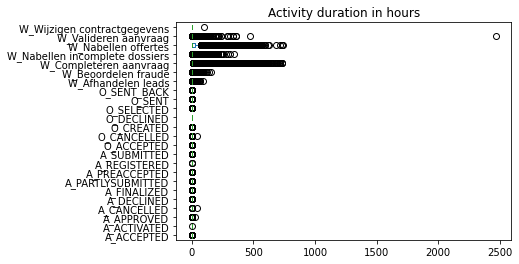

In [ ]:
fig = plt.figure()
ax = activity_duration(log2, 'case_id', 'activity', 'timestamp')\
.loc[:, ['event_from', 'event_to', 'duration (h)']]\
.reset_index()\
.pivot(columns='event_from', values='duration (h)')

#fig.set_figwidth(15)
#fig.set_figheight(10)

ax.plot(kind='box', vert=False, title='Activity duration in hours')
plt.rcParams['figure.figsize'] = (16, 10)


plt.show()

In [ ]:
new_df[new_df['duration (h)'] > 2000]

,event_from,event_to,time_from,time_to,duration (h)
case_id,,,,,
173694,W_Valideren aanvraag,W_Wijzigen contractgegevens,2011-11-04 15:05:01.532000+00:00,2012-02-15 11:29:26.299000+00:00,2468.40688


In [ ]:
log2['activity'].value_counts()

W_Completeren aanvraag            54850
W_Nabellen offertes               52016
W_Nabellen incomplete dossiers    25190
W_Valideren aanvraag              20809
W_Afhandelen leads                16566
A_SUBMITTED                       13087
A_PARTLYSUBMITTED                 13087
A_DECLINED                         7635
A_PREACCEPTED                      7367
O_SENT                             7030
O_CREATED                          7030
O_SELECTED                         7030
A_ACCEPTED                         5113
A_FINALIZED                        5015
O_CANCELLED                        3655
O_SENT_BACK                        3454
A_CANCELLED                        2807
A_REGISTERED                       2246
A_ACTIVATED                        2246
A_APPROVED                         2246
O_ACCEPTED                         2243
O_DECLINED                          802
W_Beoordelen fraude                 664
W_Wijzigen contractgegevens          12
Name: activity, dtype: int64

In [ ]:
log100 = log2[log2['case_id'].isin(log2['case_id'].value_counts()[log2['case_id'].value_counts() >= 150].index)]

In [ ]:
log100['case_id'].nunique()

7

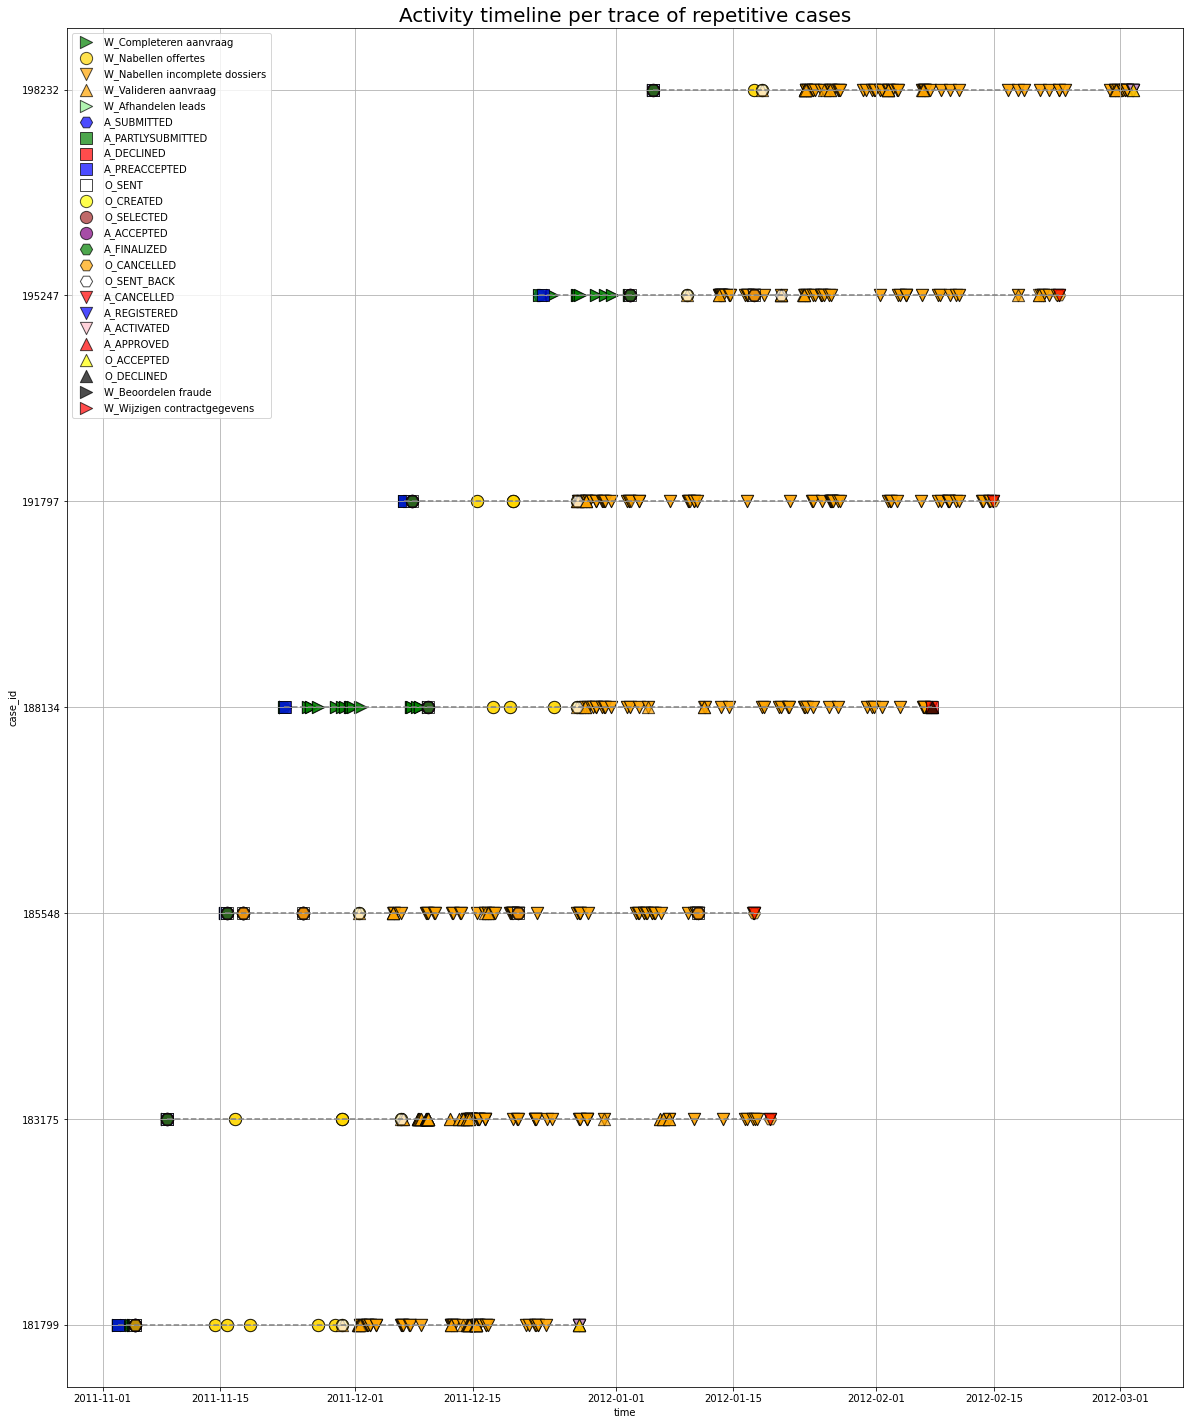

In [ ]:
# Visualize repetitive cases in eventlog ##########################################################
# Settings
activity = {
    'W_Completeren aanvraag': ('>', 'green'), 
    'W_Nabellen offertes': ('o', 'gold'), 
    'W_Nabellen incomplete dossiers': ('v', 'orange'), 
    'W_Valideren aanvraag': ('^', 'orange'), 
    'W_Afhandelen leads': ('>', 'lightgreen'), 
    'A_SUBMITTED': ('H', 'blue'), 
    'A_PARTLYSUBMITTED': ('s', 'green'), 
    'A_DECLINED': ('s', 'red'),
    'A_PREACCEPTED' : ('s', 'blue'),
    'O_SENT' : ('s', 'white'),
    'O_CREATED'   : ('o', 'yellow'),
    'O_SELECTED'  : ('o', 'brown'),
    'A_ACCEPTED'  : ('o', 'purple'),
    'A_FINALIZED' : ('H', 'green'),
    'O_CANCELLED' : ('H', 'orange'),
    'O_SENT_BACK' : ('H', 'white'),
    'A_CANCELLED' : ('v', 'red'),
    'A_REGISTERED': ('v', 'blue'),
    'A_ACTIVATED' : ('v', 'pink'),
    'A_APPROVED' :  ('^', 'red'),
    'O_ACCEPTED' :  ('^', 'yellow'),
    'O_DECLINED' :  ('^', 'black'),
    'W_Beoordelen fraude' : ('>', 'black'),
    'W_Wijzigen contractgegevens' :  ('>', 'red'),
}

# Figure
fig, ax = plt.subplots(figsize=(20, 25))

# Timelines
for timeline in log100.groupby('case_id').agg(time_start = ('timestamp', min), 
                                               time_end = ('timestamp', max)
                                              ).reset_index().itertuples(index=False):
    plt.hlines(timeline.case_id, timeline.time_start, timeline.time_end, 
               colors = 'grey', linestyles = 'dashed')

# Activities
for act in activity.keys():
    ax.scatter(log100.loc[log100.activity == act, 'timestamp'], 
               log100.loc[log100.activity == act, 'case_id'],
               marker = activity[act][0],
               color = activity[act][1], 
               s = 150, 
               alpha = .7,
               label = act,
               edgecolors = 'black',
              )
    
ax.set_title('Activity timeline per trace of repetitive cases', fontsize=20)
ax.set_xlabel('time')
ax.set_ylabel('case_id')
ax.legend()
ax.grid(True)

In [ ]:
## frequency calculation 
def dfg_frequency_matrix(
    event_log: pd.DataFrame, 
    case_var: str, 
    event_var: str, 
    timestamp_var: str
) -> pd.DataFrame:
    
    """
    Return a directly-follows graph frequency matrix based on the traces in the event log.
    Row events (i.e. the index) are events 'from' and column events are the events 'to'.
    """
    
    # event log
    log = log2[[case_var, event_var, timestamp_var]]
    
    # initiate matrix
    events = log[event_var].unique()
    matrix = pd.DataFrame(columns=events, index=events).fillna(0)
    
    # groupby case_var
    groups = log.groupby(case_var)
    
    # loop through case groups
    for group in groups:
        event = group[1].sort_values(timestamp_var)\
        .drop([case_var, timestamp_var], axis = 1)\
        .rename(columns = {event_var:'event_from'})
        event['event_to'] = event['event_from'].shift(-1)
        event.dropna(inplace = True)
        
        # loop through traces
        for trace in event.itertuples(index = False):
            matrix.at[trace.event_from, trace.event_to] += 1
                
    return matrix.replace(0, np.nan)

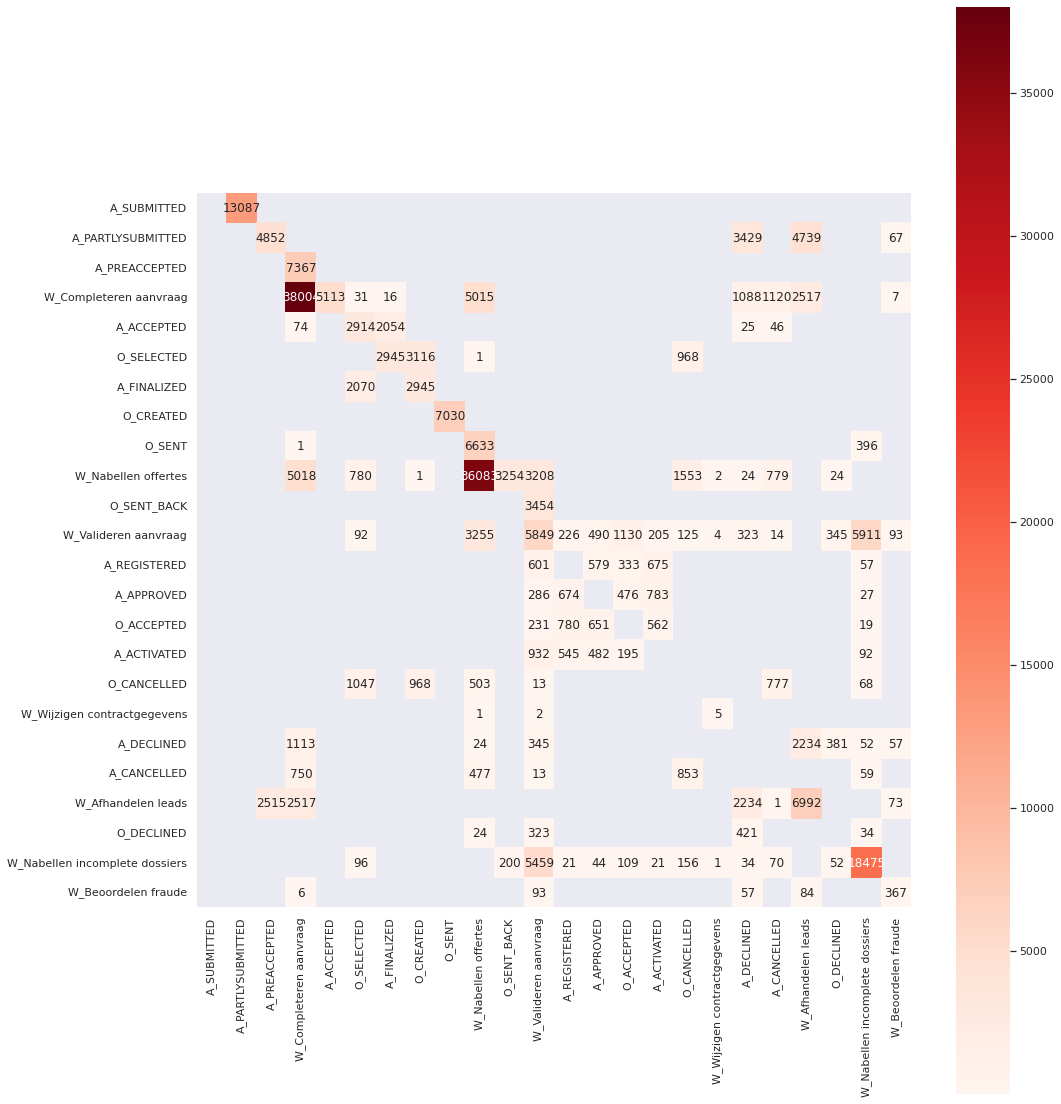

In [ ]:
# Directly-Follows Graph frequency heatmap
dfg_freq_matrix = dfg_frequency_matrix(log2, 'case_id', 'activity', 'timestamp')
sns.set(rc={'figure.figsize':(16, 20)})
sns.heatmap(dfg_freq_matrix, annot=True, fmt='.0f', cmap='Reds', square=True)
plt.show()

In [ ]:
def dfg_performance_matrix(
    event_log: pd.DataFrame, 
    case_var: str, 
    event_var: str, 
    timestamp_var: str, 
    duration: str ='h'
) -> pd.DataFrame:
    
    """
    Return a directly-follows graph duration matrix based on the traces in the event log.
    Row events (i.e. the index) are events 'from' and column events are the events 'to'.
    By default duration is set to hours (h). Use 's' for seconds, 'D' for days and 'W' for weeks.
    """
    
    # event log
    log = log2[[case_var, event_var, timestamp_var]]
    
    # initiate matrix
    events = log[event_var].unique()
    matrix = pd.DataFrame(columns=events, index=events)
    
    # groupby case_var
    groups = log.groupby(case_var)
    
    # loop through case groups
    for group in groups:
        event = group[1].sort_values(timestamp_var)\
        .rename(columns = {event_var:'event_from', timestamp_var:'time_begin'})
        event['event_to'] = event['event_from'].shift(-1)
        event['time_end'] = event['time_begin'].shift(-1)
        event['duration'] = (event['time_end'] - event['time_begin']) / np.timedelta64(1, duration)
        event.dropna(inplace = True)
        
        # loop through traces
        for row in event.itertuples(index = False):
            matrix.at[row.event_from, row.event_to] = \
            np.nansum([matrix.at[row.event_from, row.event_to], row.duration])
    
    return matrix.astype(float)

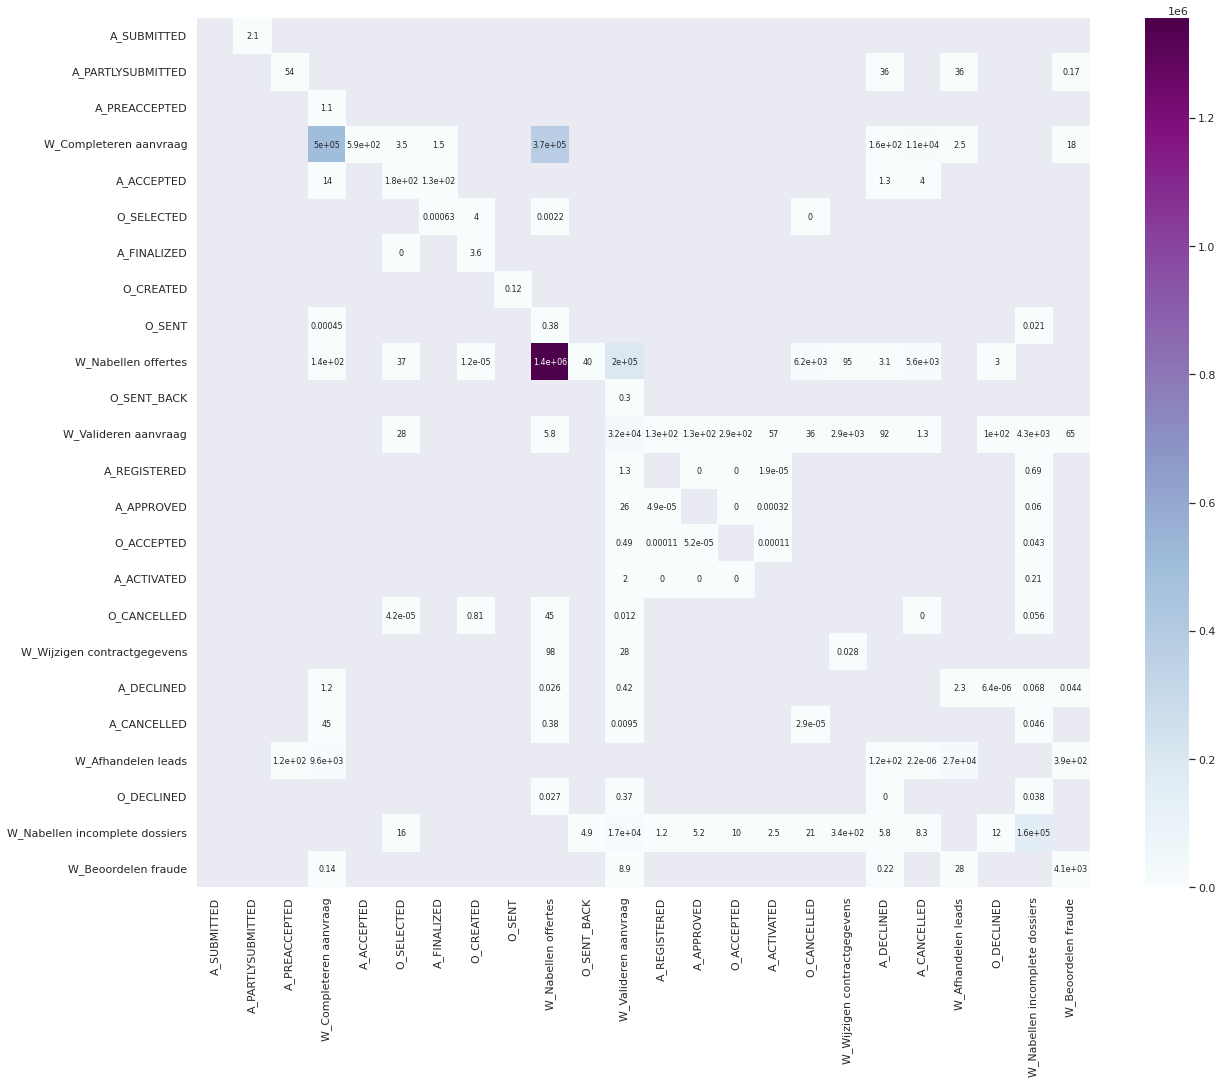

In [ ]:
# Directly-Follows Graph total duration heapmap (in hours)
dfg_perf_matrix = dfg_performance_matrix(log2, 'case_id', 'activity', 'timestamp', duration='h')
sns.set(rc={'figure.figsize':(20, 16)})
sns.heatmap(dfg_perf_matrix, annot=True, cmap='BuPu', annot_kws={"size": 8})
plt.show()

In [ ]:
def dfg_frequency_table(dfg_frequency_matrix: pd.DataFrame) -> pd.DataFrame:
    
    """
    Returns an directly-follows graph frequency table
    """
    
    arcs = list()
    
    for row in dfg_frequency_matrix.index:
        for col in dfg_frequency_matrix.columns:
            if not np.isnan(dfg_frequency_matrix.at[row, col]):
                arcs.append((row, col, dfg_frequency_matrix.at[row, col]))
    
    arc_freq = pd.DataFrame(arcs, columns = ['event_from', 'event_to', 'frequency'])\
    .set_index(['event_from', 'event_to'])
    
    return arc_freq

In [ ]:
dfg_frequency_table(dfg_frequency_matrix(log2, 'case_id', 'activity', 'timestamp'))

frequency
event_from          event_to                         
A_SUBMITTED         A_PARTLYSUBMITTED         13087.0
A_PARTLYSUBMITTED   A_PREACCEPTED              4852.0
                    A_DECLINED                 3429.0
                    W_Afhandelen leads         4739.0
                    W_Beoordelen fraude          67.0
...                                               ...
W_Beoordelen fraude W_Completeren aanvraag        6.0
                    W_Valideren aanvraag         93.0
                    A_DECLINED                   57.0
                    W_Afhandelen leads           84.0
                    W_Beoordelen fraude         367.0

[125 rows x 1 columns]

In [ ]:
# Directly-Follows Graph frequency and performance (in hours) table
df = pd.merge(
    dfg_frequency_table(
        dfg_frequency_matrix(log2, 'case_id', 'activity', 'timestamp'))\
    .reset_index(),
    activity_duration(log2, 'case_id', 'activity', 'timestamp')\
    .loc[:, ['event_from', 'event_to', 'duration (h)']]\
    .groupby(by = ['event_from', 'event_to']).mean('duration (h)')\
    .reset_index(),
    left_on = ['event_from', 'event_to'],
    right_on = ['event_from', 'event_to']
).rename(columns = {'duration (h)':'average_duration'})

df['average_duration'] = df['average_duration'].apply(lambda x: np.round(x, decimals=2))
df['frequency'] = df['frequency'].astype(int)
df['total_duration'] = df['frequency'] * df['average_duration']

df.sort_values(['total_duration', 'average_duration', 'frequency'], ascending=False)

,event_from,event_to,frequency,average_duration,total_duration
33,W_Nabellen offertes,W_Nabellen offertes,36083,37.83,1365019.89
6,W_Completeren aanvraag,W_Completeren aanvraag,38004,13.22,502412.88
10,W_Completeren aanvraag,W_Nabellen offertes,5015,77.01,386205.15
35,W_Nabellen offertes,W_Valideren aanvraag,3208,60.10,192800.80
118,W_Nabellen incomplete dossiers,W_Nabellen incomplete dossiers,18475,8.73,161286.75
...,...,...,...,...,...
93,A_CANCELLED,W_Valideren aanvraag,13,0.00,0.00
22,O_SELECTED,W_Nabellen offertes,1,0.00,0.00
27,O_SENT,W_Completeren aanvraag,1,0.00,0.00
32,W_Nabellen offertes,O_CREATED,1,0.00,0.00


## PM4PY

In [10]:
log2.head()

,case_id,activity,timestamp,org:resource
0,173688,A_SUBMITTED,2011-09-30 22:38:44.546000+00:00,112
1,173688,A_PARTLYSUBMITTED,2011-09-30 22:38:44.880000+00:00,112
2,173688,A_PREACCEPTED,2011-09-30 22:39:37.906000+00:00,112
3,173688,W_Completeren aanvraag,2011-09-30 22:39:38.875000+00:00,112
4,173688,W_Completeren aanvraag,2011-10-01 09:36:46.437000+00:00,NaN


In [11]:
# Assign Variables
event_log = pm4py.format_dataframe(
    log2,
    case_id = 'case_id',
    activity_key = 'activity',
    timestamp_key = 'timestamp', 
    timest_format = '%Y-%m-%d %H:%M:%S%z'
)

In [12]:
# Chechking start and end activities of traces
start_activities = pm4py.get_start_activities(log2)
end_activities = pm4py.get_end_activities(log2)
print(f'Start activities: {start_activities}')
print(f'End activities  : {end_activities}')

Start activities: {'A_SUBMITTED': 13087}
End activities  : {'A_DECLINED': 3429, 'W_Valideren aanvraag': 2747, 'W_Afhandelen leads': 2234, 'W_Completeren aanvraag': 1939, 'W_Nabellen offertes': 1290, 'A_CANCELLED': 655, 'W_Nabellen incomplete dossiers': 452, 'O_CANCELLED': 279, 'W_Beoordelen fraude': 57, 'W_Wijzigen contractgegevens': 4, 'A_REGISTERED': 1}


In [13]:
# Event Log object
log = xes_importer.apply('/content/drive/MyDrive/financial_log.xes')

parsing log, completed traces ::   0%|          | 0/13087 [00:00<?, ?it/s]

In [14]:
type(log)

pm4py.objects.log.obj.EventLog

In [15]:
type(log[0])

pm4py.objects.log.obj.Trace

In [16]:
type(log[0][0])

pm4py.objects.log.obj.Event

In [17]:
print(log[0])

{'attributes': {'REG_DATE': datetime.datetime(2011, 10, 1, 0, 38, 44, 546000, tzinfo=datetime.timezone(datetime.timedelta(seconds=7200))), 'concept:name': '173688', 'AMOUNT_REQ': '20000'}, 'events': [{'org:resource': '112', 'lifecycle:transition': 'COMPLETE', 'concept:name': 'A_SUBMITTED', 'time:timestamp': datetime.datetime(2011, 10, 1, 0, 38, 44, 546000, tzinfo=datetime.timezone(datetime.timedelta(seconds=7200)))}, '..', {'org:resource': '10629', 'lifecycle:transition': 'COMPLETE', 'concept:name': 'W_Valideren aanvraag', 'time:timestamp': datetime.datetime(2011, 10, 13, 10, 37, 37, 26000, tzinfo=datetime.timezone(datetime.timedelta(seconds=7200)))}]}


In [18]:
## Printing the first trace
log[0]

{'attributes': {'REG_DATE': datetime.datetime(2011, 10, 1, 0, 38, 44, 546000, tzinfo=datetime.timezone(datetime.timedelta(seconds=7200))), 'concept:name': '173688', 'AMOUNT_REQ': '20000'}, 'events': [{'org:resource': '112', 'lifecycle:transition': 'COMPLETE', 'concept:name': 'A_SUBMITTED', 'time:timestamp': datetime.datetime(2011, 10, 1, 0, 38, 44, 546000, tzinfo=datetime.timezone(datetime.timedelta(seconds=7200)))}, '..', {'org:resource': '10629', 'lifecycle:transition': 'COMPLETE', 'concept:name': 'W_Valideren aanvraag', 'time:timestamp': datetime.datetime(2011, 10, 13, 10, 37, 37, 26000, tzinfo=datetime.timezone(datetime.timedelta(seconds=7200)))}]}

In [19]:
## printing the first event in first trace
log[0][0]

{'org:resource': '112', 'lifecycle:transition': 'COMPLETE', 'concept:name': 'A_SUBMITTED', 'time:timestamp': datetime.datetime(2011, 10, 1, 0, 38, 44, 546000, tzinfo=datetime.timezone(datetime.timedelta(seconds=7200)))}

In [20]:
# concept:name (i.e case_id):13087 cases log
len([trace.attributes['concept:name'] for trace in log])

13087

In [21]:
# Start Activity
pm4py.get_start_activities(log)

{'A_SUBMITTED': 13087}

In [23]:
# End activity
pm4py.get_end_activities(log)

{'W_Valideren aanvraag': 2747,
 'W_Wijzigen contractgegevens': 4,
 'A_DECLINED': 3429,
 'W_Completeren aanvraag': 1939,
 'A_CANCELLED': 655,
 'W_Nabellen incomplete dossiers': 452,
 'W_Afhandelen leads': 2234,
 'W_Nabellen offertes': 1290,
 'W_Beoordelen fraude': 57,
 'O_CANCELLED': 279,
 'A_REGISTERED': 1}

In [66]:
#Filter cases having 'A_REGISTERED' end activity in the provided list(Case Trace)
filtered_REG = pm4py.filter_end_activities(event_log, {'A_REGISTERED'})
filtered_REG

,case_id,activity,timestamp,org:resource,case:concept:name,concept:name,time:timestamp,@@index,@@case_index
44523,180310,A_SUBMITTED,2011-10-27 14:58:16.129000+00:00,112,180310,A_SUBMITTED,2011-10-27 14:58:16.129000+00:00,44523,2099
44524,180310,A_PARTLYSUBMITTED,2011-10-27 14:58:16.736000+00:00,112,180310,A_PARTLYSUBMITTED,2011-10-27 14:58:16.736000+00:00,44524,2099
44525,180310,A_PREACCEPTED,2011-10-27 14:59:03.533000+00:00,112,180310,A_PREACCEPTED,2011-10-27 14:59:03.533000+00:00,44525,2099
44526,180310,W_Completeren aanvraag,2011-10-27 14:59:04.080000+00:00,112,180310,W_Completeren aanvraag,2011-10-27 14:59:04.080000+00:00,44526,2099
44527,180310,W_Completeren aanvraag,2011-10-27 14:59:17.948000+00:00,10982,180310,W_Completeren aanvraag,2011-10-27 14:59:17.948000+00:00,44527,2099
44528,180310,A_ACCEPTED,2011-10-27 15:01:14.957000+00:00,10982,180310,A_ACCEPTED,2011-10-27 15:01:14.957000+00:00,44528,2099
44529,180310,O_SELECTED,2011-10-27 15:02:39.212000+00:00,10982,180310,O_SELECTED,2011-10-27 15:02:39.212000+00:00,44529,2099
44530,180310,A_FINALIZED,2011-10-27 15:02:39.213000+00:00,10982,180310,A_FINALIZED,2011-10-27 15:02:39.213000+00:00,44530,2099
44531,180310,O_CREATED,2011-10-27 15:02:40.368000+00:00,10982,180310,O_CREATED,2011-10-27 15:02:40.368000+00:00,44531,2099
44532,180310,O_SENT,2011-10-27 15:02:40.399000+00:00,10982,180310,O_SENT,2011-10-27 15:02:40.399000+00:00,44532,2099


In [70]:
#Filter to find cases having 'W_Wijzigen contractgegevens' end activity 
filtered_Contract = pm4py.filter_end_activities(event_log, {'W_Wijzigen contractgegevens'})
set(filtered_Contract['case_id'])

{'173694', '191464', '191737', '204523'}

In [24]:
# Filter on end activity 'W_Beoordelen fraude'
Beoordelen_fraude= pm4py.filter_end_activities(log, {'W_Beoordelen fraude'})
Beoordelen_fraude

[{'attributes': {'REG_DATE': datetime.datetime(2011, 10, 1, 14, 50, 9, 763000, tzinfo=datetime.timezone(datetime.timedelta(seconds=7200))), 'concept:name': '173754', 'AMOUNT_REQ': '20000'}, 'events': [{'org:resource': '112', 'lifecycle:transition': 'COMPLETE', 'concept:name': 'A_SUBMITTED', 'time:timestamp': datetime.datetime(2011, 10, 1, 14, 50, 9, 763000, tzinfo=datetime.timezone(datetime.timedelta(seconds=7200)))}, '..', {'org:resource': '10809', 'lifecycle:transition': 'COMPLETE', 'concept:name': 'W_Beoordelen fraude', 'time:timestamp': datetime.datetime(2011, 10, 14, 14, 28, 41, 859000, tzinfo=datetime.timezone(datetime.timedelta(seconds=7200)))}]}, '....', {'attributes': {'REG_DATE': datetime.datetime(2012, 2, 27, 20, 52, 28, 252000, tzinfo=datetime.timezone(datetime.timedelta(seconds=3600))), 'concept:name': '213522', 'AMOUNT_REQ': '13612'}, 'events': [{'org:resource': '112', 'lifecycle:transition': 'COMPLETE', 'concept:name': 'A_SUBMITTED', 'time:timestamp': datetime.datetime(2

In [25]:
# Traces (i.e. case_id) with end activity ''W_Beoordelen fraude'
for trace in Beoordelen_fraude:
    print(trace.attributes['concept:name'])

173754
173916
174734
174755
175000
176599
177705
178437
178542
180148
180178
181891
182792
184039
184168
184586
184718
185099
185258
185825
185999
186646
186980
187684
187741
187912
188410
189103
189367
189499
190779
191764
192016
192031
192277
192434
196807
197039
197482
197785
198774
199648
200991
201102
202445
203278
204248
204694
205712
206784
207263
208895
209141
210963
211396
213186
213522


In [26]:
#Number of variants
variants = variants_filter.get_variants(log)
print(f"Number of variants:{len(variants)}")

Number of variants:4366


In [27]:
# 10 Top variants by number of repetitions
variants = pm4py.statistics.variants.log.get.get_variants_from_log_trace_idx(log)
variants_count = pm4py.statistics.variants.log.get.get_variants_sorted_by_count(variants)
variants_count[:10]

[[('A_SUBMITTED', 'A_PARTLYSUBMITTED', 'A_DECLINED'), 3429],
 [('A_SUBMITTED',
   'A_PARTLYSUBMITTED',
   'W_Afhandelen leads',
   'W_Afhandelen leads',
   'A_DECLINED',
   'W_Afhandelen leads'),
  1872],
 [('A_SUBMITTED',
   'A_PARTLYSUBMITTED',
   'W_Afhandelen leads',
   'W_Afhandelen leads',
   'W_Afhandelen leads',
   'W_Afhandelen leads',
   'A_DECLINED',
   'W_Afhandelen leads'),
  271],
 [('A_SUBMITTED',
   'A_PARTLYSUBMITTED',
   'W_Afhandelen leads',
   'W_Afhandelen leads',
   'A_PREACCEPTED',
   'W_Completeren aanvraag',
   'W_Afhandelen leads',
   'W_Completeren aanvraag',
   'A_DECLINED',
   'W_Completeren aanvraag'),
  209],
 [('A_SUBMITTED',
   'A_PARTLYSUBMITTED',
   'A_PREACCEPTED',
   'W_Completeren aanvraag',
   'W_Completeren aanvraag',
   'A_DECLINED',
   'W_Completeren aanvraag'),
  160],
 [('A_SUBMITTED',
   'A_PARTLYSUBMITTED',
   'A_PREACCEPTED',
   'W_Completeren aanvraag',
   'W_Completeren aanvraag',
   'A_CANCELLED',
   'W_Completeren aanvraag'),
  134],
 

### 3429 of 13087 cases have only 3 events in their journey(i.e 26%).In other words, Journey of 26 cases is only in 1 variant of 4306  available variants(i.e 0.02%)

In [42]:
## Number of activities that available in event log 
activities = attributes.log.get.get_attribute_values(log, "concept:name")  
activities

{'A_SUBMITTED': 13087,
 'A_PARTLYSUBMITTED': 13087,
 'A_PREACCEPTED': 7367,
 'W_Completeren aanvraag': 54850,
 'A_ACCEPTED': 5113,
 'O_SELECTED': 7030,
 'A_FINALIZED': 5015,
 'O_CREATED': 7030,
 'O_SENT': 7030,
 'W_Nabellen offertes': 52016,
 'O_SENT_BACK': 3454,
 'W_Valideren aanvraag': 20809,
 'A_REGISTERED': 2246,
 'A_APPROVED': 2246,
 'O_ACCEPTED': 2243,
 'A_ACTIVATED': 2246,
 'O_CANCELLED': 3655,
 'W_Wijzigen contractgegevens': 12,
 'A_DECLINED': 7635,
 'A_CANCELLED': 2807,
 'W_Afhandelen leads': 16566,
 'O_DECLINED': 802,
 'W_Nabellen incomplete dossiers': 25190,
 'W_Beoordelen fraude': 664}

In [38]:
#Get number of times for which two activities have been concurrent in the log
concurrent = statistics.concurrent_activities.log.get.apply(log)
concurrent

{('A_FINALIZED', 'O_SELECTED'): 4289,
 ('A_APPROVED', 'A_REGISTERED'): 1662,
 ('A_REGISTERED', 'O_ACCEPTED'): 1126,
 ('A_ACTIVATED', 'A_REGISTERED'): 2050,
 ('A_APPROVED', 'O_ACCEPTED'): 1698,
 ('A_ACTIVATED', 'A_APPROVED'): 1466,
 ('A_ACTIVATED', 'O_ACCEPTED'): 938,
 ('O_CANCELLED', 'O_SELECTED'): 1875,
 ('A_DECLINED', 'O_DECLINED'): 779,
 ('A_CANCELLED', 'O_CANCELLED'): 1582,
 ('W_Beoordelen fraude', 'W_Valideren aanvraag'): 2,
 ('A_CANCELLED', 'W_Nabellen offertes'): 29,
 ('O_CANCELLED', 'W_Nabellen offertes'): 30,
 ('A_CANCELLED', 'W_Completeren aanvraag'): 28}

In [43]:
# Filter methods
[_ for _ in dir(pm4py) if _.startswith('filter')]

['filter_activities_rework',
 'filter_activity_done_different_resources',
 'filter_between',
 'filter_case_performance',
 'filter_case_size',
 'filter_directly_follows_relation',
 'filter_end_activities',
 'filter_event_attribute_values',
 'filter_eventually_follows_relation',
 'filter_four_eyes_principle',
 'filter_log',
 'filter_log_relative_occurrence_event_attribute',
 'filter_ocel_cc_object',
 'filter_ocel_end_events_per_object_type',
 'filter_ocel_event_attribute',
 'filter_ocel_events',
 'filter_ocel_events_timestamp',
 'filter_ocel_object_attribute',
 'filter_ocel_object_per_type_count',
 'filter_ocel_object_types',
 'filter_ocel_object_types_allowed_activities',
 'filter_ocel_objects',
 'filter_ocel_start_events_per_object_type',
 'filter_paths_performance',
 'filter_prefixes',
 'filter_start_activities',
 'filter_suffixes',
 'filter_time_range',
 'filter_trace',
 'filter_trace_attribute_values',
 'filter_variants',
 'filter_variants_by_coverage_percentage',
 'filter_variants_

In [51]:
# Filter on traces that did start and end in 2011
start_datetime = datetime.datetime(2012, 1, 1, 0, 0, 0, 0)
end_datetime = datetime.datetime(2012, 12, 31, 23, 59, 59, 999999)
log_2012 = pm4py.filter_time_range(log, start_datetime, end_datetime, mode='traces_contained')

# Print case_id's (traces) in 20111
for trace in log_2012:
    print(trace.attributes['concept:name'])
print(f'{len(log_2012)} cases occurred in 2012')

Streaming output truncated to the last 5000 lines.
198870
198873
198876
198879
198882
198885
198888
198891
198894
198897
198900
198903
198906
198909
198912
198915
198918
198921
198924
198927
198930
198933
198936
198939
198942
198945
198948
198951
198954
198957
198960
198963
198966
198969
198972
198975
198978
198981
198984
198987
198990
198993
198996
198999
199002
199005
199008
199011
199014
199017
199020
199023
199026
199029
199032
199035
199038
199041
199044
199047
199050
199053
199056
199059
199062
199065
199068
199071
199074
199077
199080
199083
199086
199089
199092
199095
199098
199101
199104
199107
199110
199113
199116
199119
199122
199125
199128
199131
199134
199137
199140
199143
199146
199149
199159
199162
199165
199168
199171
199174
199177
199180
199183
199186
199189
199192
199195
199198
199201
199204
199207
199210
199213
199216
199219
199222
199225
199228
199231
199234
199237
199240
199243
199246
199249
199252
199255
199258
199261
199264
199267
199270
199273
199276
199279
1992

In [ ]:
#from pm4py.statistics.overlap.cases.log import get as case_overlap_get
#overlap = case_overlap_get.apply(log)
#overlap

In [115]:
# Filters the cases where an activity is repeated by different resources
repeat_incomplete_dossiers = pm4py.filter_activity_done_different_resources(log, 'W_Nabellen incomplete dossiers')
repeat_incomplete_dossiers[0:10]

[{'attributes': {'REG_DATE': datetime.datetime(2011, 10, 1, 10, 37, 39, 362000, tzinfo=datetime.timezone(datetime.timedelta(seconds=7200))), 'concept:name': '173718', 'AMOUNT_REQ': '15000'}, 'events': [{'org:resource': '112', 'lifecycle:transition': 'COMPLETE', 'concept:name': 'A_SUBMITTED', 'time:timestamp': datetime.datetime(2011, 10, 1, 10, 37, 39, 363000, tzinfo=datetime.timezone(datetime.timedelta(seconds=7200)))}, '..', {'org:resource': '10972', 'lifecycle:transition': 'COMPLETE', 'concept:name': 'W_Valideren aanvraag', 'time:timestamp': datetime.datetime(2011, 10, 27, 9, 18, 1, 790000, tzinfo=datetime.timezone(datetime.timedelta(seconds=7200)))}]},
 {'attributes': {'REG_DATE': datetime.datetime(2011, 10, 1, 11, 7, 34, 279000, tzinfo=datetime.timezone(datetime.timedelta(seconds=7200))), 'concept:name': '173721', 'AMOUNT_REQ': '9000'}, 'events': [{'org:resource': '112', 'lifecycle:transition': 'COMPLETE', 'concept:name': 'A_SUBMITTED', 'time:timestamp': datetime.datetime(2011, 10,

In [118]:
repeat_incomplete_dossiers[0].attributes['concept:name']

'173718'

## Data Exploration

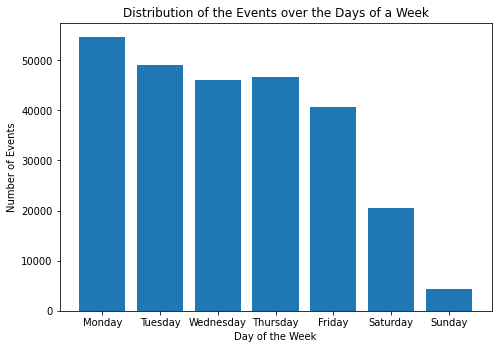

In [121]:
# Events per Day
pm4py.view_events_distribution_graph(log, distr_type="days_week") 

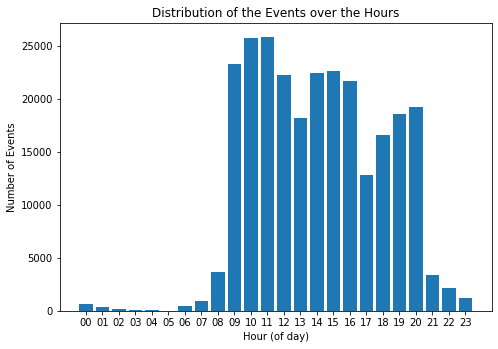

In [122]:
# Events per Hour
pm4py.view_events_distribution_graph(log, distr_type="hours")

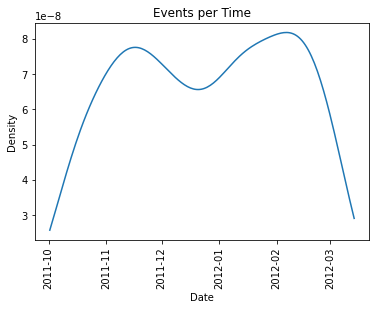

In [123]:
# Event Distribution Plot
pm4py.view_events_per_time_graph(log)

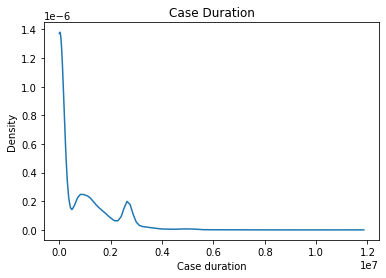

In [124]:
# Case Duration Distribution
pm4py.view_case_duration_graph(log)